In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

<xarray.Dataset>
Dimensions:  (xh: 640, y: 640, z: 3328, time: 1)
Coordinates:
  * xh       (xh) float32 0.0 0.04279 0.08558 0.1284 ... 27.21 27.26 27.3 27.34
  * y        (y) float32 0.0214 0.06419 0.107 0.1498 ... 27.24 27.28 27.32 27.36
  * z        (z) float32 0.002716 0.008147 0.01358 0.01901 ... 18.06 18.07 18.07
  * time     (time) int32 -2147483647
Data variables:
    u        (time, z, y, xh) float32 ...
Plot spectra plot for time 616000 at height [2.1208613]
Plot spectra plot for time 616000 at height [10.028605]
<xarray.Dataset>
Dimensions:  (xh: 640, y: 640, z: 3328, time: 1)
Coordinates:
  * xh       (xh) float32 0.0 0.04279 0.08558 0.1284 ... 27.21 27.26 27.3 27.34
  * y        (y) float32 0.0214 0.06419 0.107 0.1498 ... 27.24 27.28 27.32 27.36
  * z        (z) float32 0.002716 0.008147 0.01358 0.01901 ... 18.06 18.07 18.07
  * time     (time) int32 -2147483647
Data variables:
    u        (time, z, y, xh) float32 ...
Plot spectra plot for time 630000 at height [2.1208613

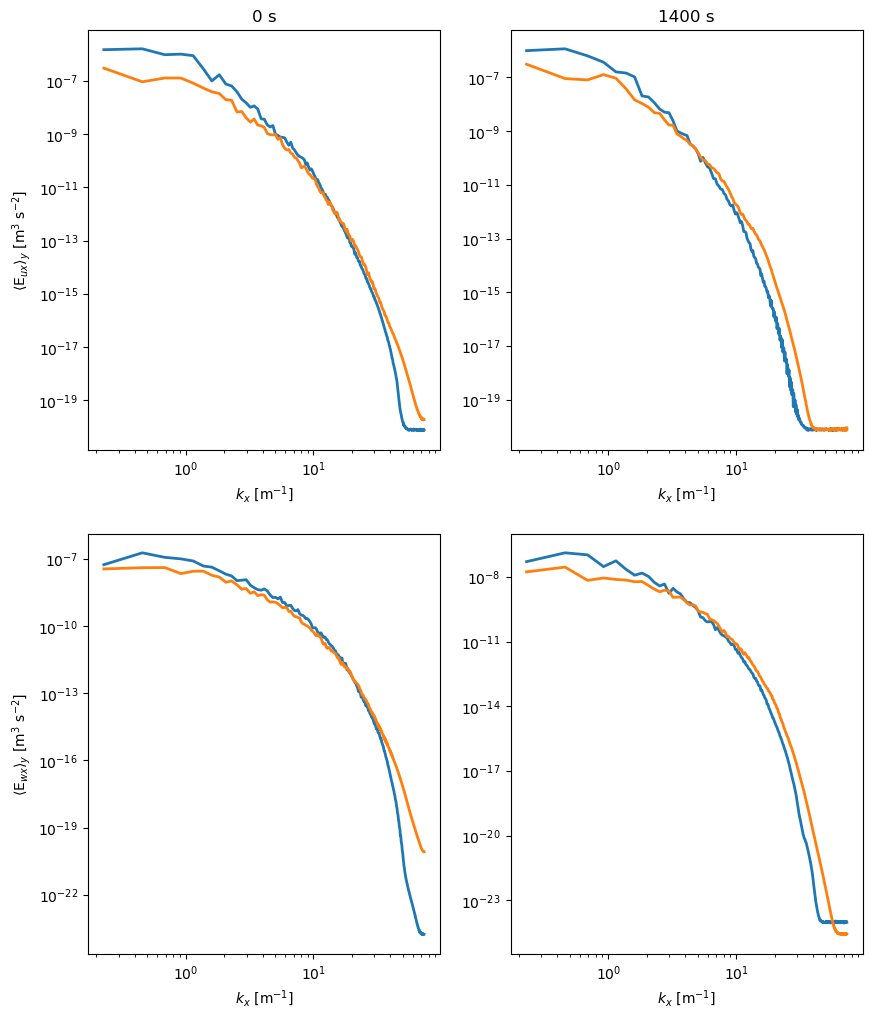

In [2]:
# var_all=['u','v','w']
# Re_all=['Re900/','Re1800/','Re2700/']
# timesteps_all=[[600000],[623000],[1377000]]
var_all=['u','v','w','b']
var_all=['u','w']#,'v','w','b']
ylabels=[r"$\langle$E$_{ux} \rangle_y$ [m$^{3}$ s$^{-2}]$",r"$\langle$E$_{wx} \rangle_y$ [m$^{3}$ s$^{-2}]$"]
Re_all=['Re1800/']
# timesteps_all=[[616000,624000]]
timesteps_all=[[616000,630000]]
# timesteps_all=[[616000]]
# timesteps_all=[[630000]]
hgts_c=[ 2.12, 10.03]
hgts_h=[ 2.26, 9.88]
hgtStr=['2 m','10 m']

fig,axs=plt.subplots(len(var_all),len(timesteps_all[0]),figsize=(10,12))
save=True
outdir=""

for ivar in range(len(var_all)):
    var=var_all[ivar]
    for iRe in range(len(Re_all)):
        Re=Re_all[iRe]
        path='/glade/u/home/adac/work/DNSdata/DNS_SBL_L320/'+Re
        timesteps=timesteps_all[iRe]
        nt=len(timesteps)

        for it,timestep in enumerate(timesteps):
            
            ds = xr.open_dataset(path+var+str(timestep)+'.nc',decode_times=0)
            print(ds)

            w=ds[var][0].values

            try:
              x=ds['xh'].values
            except:
              x=ds['x'].values
            nx=len(x)
            dx=np.mean(np.diff(x))

            try:
              y=ds['yh'].values
            except:
              y=ds['y'].values
            ny=len(y)

            try:
              z=ds['zh'].values
              hgts=hgts_h
            except:
              z=ds['z'].values
              hgts=hgts_c

            for ihgt,hgt in enumerate(hgts):
                
                k=[(np.abs(z - hgt)).argmin()]
    
                kxy = 2*np.pi*np.fft.rfftfreq(nx,d=dx)
                dk=kxy[1] # should be smallest wavenumber 2pi/(length_fline*dx)
                lenf=len(kxy)# length_fline/2+1
                sp = np.empty([ny,lenf])
                #sp = np.empty([nF,avgt,length_yline,lenf])
                #sP = np.empty([nF,lenf])
                print('Plot spectra plot for time '+str(timestep)+' at height '+str(z[k]))
                #Can make use of below loop if we want to loop through files but b/c the NBL is developping probably shouldn't
                #  for F in range(nF): # File index
                #    for i in range(avgt): # Time index
                #      for ix in range(length_fline): # x (lon) index
                #        for iy in range(length_yline): # y (lat) index
                #          Wall[F,i,ix,iy]=fsall[F][nstart+i].variables['W'][nsall[F][nstart+i]][k][(Y1+iy),(X1+ix)]
                           # Wdiag = np.array([fsall[F][nstart+i].variables['W'][nsall[F][nstart+i]][k][Y1-count,X1] for count in range(length_fline)])
                            #normalize spectra values
                #    for i in range(avgt):
                #      for iy in range(length_yline):
    
                #Different detrending options
                #N = np.linspace(0,Wall[F,i,0,iy]-Wall[F,i,-1,iy],Wall[F,i,:,iy].shape[0])
                #N = -np.mean(Wall[F,i,:,iy])
                N=0 # detrending not necessary b/c periodic BCs
                for j in range(ny):
                    # sp_tmp = np.fft.rfft(w[k,j,:]+N)
                    sp_tmp = np.fft.rfft(w[k,:,j]+N)
                    sp[j,:] = (np.power(sp_tmp.real,2) + np.power(sp_tmp.imag,2))*dx/2.0/np.pi/nx #missing factor of two from Durran paper neccesary for the parseval's thereom to work
                    #sp[j,-1] = sp[j,-1]/2.0 #Nyquist frequency (last entry by order of reqdiag) is unique for even pts FFT, so has twice the power
                    sp[j,0] = sp[j,0]/2.0 # Calculating the 0 wavenumber, won't be plotted on a log log but just to check the assumption of zero power at zero wavenumber for different detrending methods
                    #Confirming calcs throuch Parseval's theorem
                    #wsqr=np.sum(np.power(w[k,j],2))/nx/2.0
                    #wsqr_fft=np.sum(sp[j])*dk
                    #print(wsqr,wsqr_fft)
    
                sP = np.mean(sp,axis=0)
                power = abs(sP)
    
                axs[ivar,it].loglog(kxy[1:],power[1:],linewidth=2,label='DNS '+hgtStr[ihgt])
                
            axs[0,it].set_title(str(int((timestep-timesteps[0])/10))+' s')
            # axs[ivar,it].legend()
            
            axs[ivar,it].set_xlabel(r"$k_x$ [m$^{-1}$]")#,fontsize=fs)
    axs[ivar,0].set_ylabel(ylabels[ivar])#,fontsize=fs)
    # ymin,ymax=axs[ivar].get_ylim()
    # kLES=kxy[-1]/np.array([4*15,4*30,4*60])*2
    # dxLES=['1.7','3.4','6.8'] # filter spacing (4*dx)
    # text_x=np.array([7.5e-1, 7e-1, 5.9e-1])*kLES
    # for ik in range(kLES.shape[0]):
    #     axs[ivar].loglog((kLES[ik],kLES[ik]),(ymin,ymax),'k--')
    #     print(2e-1*ymin)
    #     axs[ivar].text(text_x[ik],2e-1*ymin,r"$\Delta f_h=$"+dxLES[ik]+" m")
    # axs[ivar].tick_params('x', length=10, which='major')    

In [3]:
# del(fig,axs)
# fig,axs=plt.subplots(len(var_all),2,figsize=(10,16))

<xarray.Dataset>
Dimensions:  (time: 15, z: 64, y: 32, xh: 32)
Coordinates:
  * time     (time) float64 0.0 100.0 200.0 300.0 ... 1.2e+03 1.3e+03 1.4e+03
  * z        (z) float64 0.1412 0.4236 0.706 0.9885 ... 17.09 17.37 17.65 17.93
  * y        (y) float64 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * xh       (xh) float64 0.0 0.8558 1.712 2.567 ... 23.96 24.82 25.67 26.53
Data variables:
    u        (time, z, y, xh) float64 ...
Plot spectra plot for time 0 at height [2.11814583]
Plot spectra plot for time 0 at height [10.02589025]
Plot spectra plot for time 14 at height [2.11814583]
Plot spectra plot for time 14 at height [10.02589025]
<xarray.Dataset>
Dimensions:  (time: 15, y: 32, x: 32, zh: 64)
Coordinates:
  * time     (time) float64 0.0 100.0 200.0 300.0 ... 1.2e+03 1.3e+03 1.4e+03
  * y        (y) float64 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * x        (x) float64 0.4279 1.284 2.14 2.995 ... 24.39 25.25 26.1 26.96
  * zh       (zh) float64 0.0 0.2824 

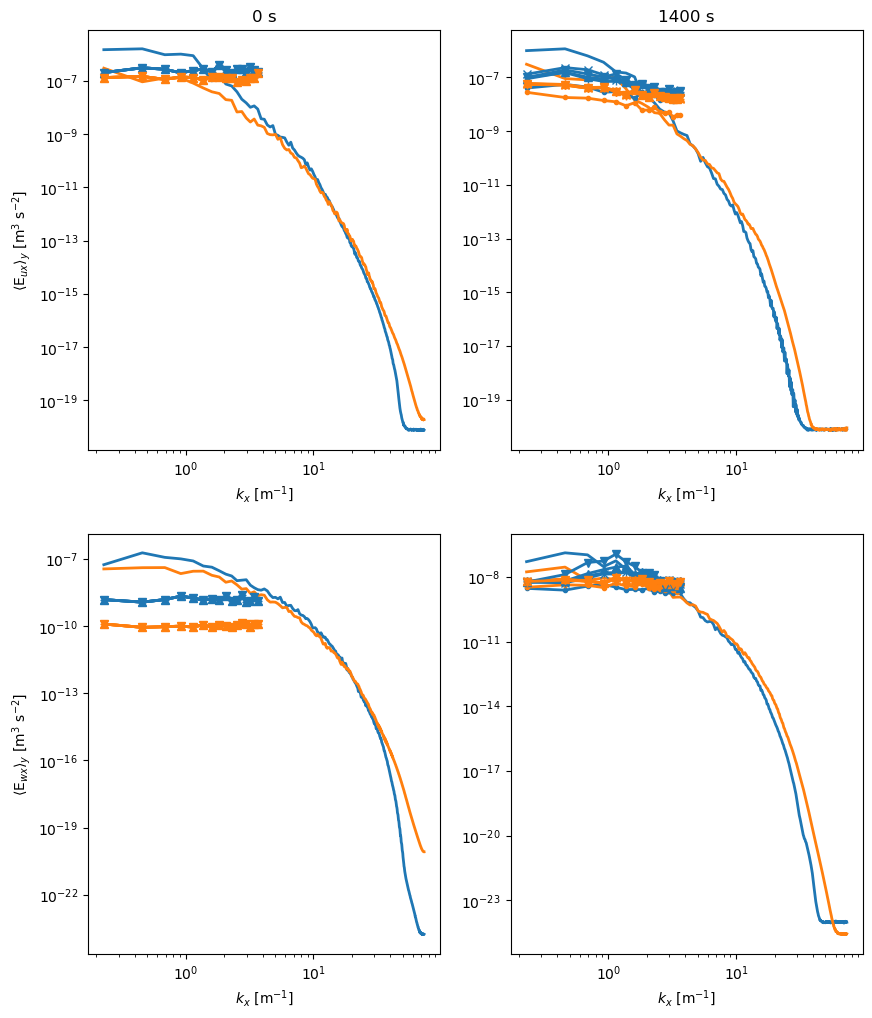

In [4]:
paths=['../cases/SBL_smag_midGridmidRe/','../cases/SBL_stats_midGridReInterp/', '../cases/SBL_stats_midReGridInterp/', '../cases/SBL_global_midGridReInterp/', '../cases/SBL_global_midReGridInterp/']
pathLabels=['Smagorinsky','Stats. Re interp.','Stats. res. interp.','Phys. Re interp.','Phys. res. interp.']
markers = ['.','x','+','^','v']
# timesteps_all=[[0,14]]
# timesteps_all=[range(0,15,7)]
timesteps_all=[[0,14]]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for iRe in range(len(Re_all)):
    timesteps=timesteps_all[iRe]
    for iLES in range(len(paths)):
        path=paths[iLES]
        marker=markers[iLES]
        for ivar in range(len(var_all)):

            var=var_all[ivar]
            ds = xr.open_dataset(path+var+'.nc')
            print(ds)

            Re=Re_all[iRe]
            timesteps=timesteps_all[iRe]
            nt=len(timesteps)

            for it,timestep in enumerate(timesteps):
                try:
                    w=ds[var][timestep].values
                except:
                    break
                    
                try:
                  x=ds['xh'].values
                except:
                  x=ds['x'].values
                nx=len(x)
                dx=np.mean(np.diff(x))

                try:
                  y=ds['yh'].values
                except:
                  y=ds['y'].values
                ny=len(y)
    
                try:
                  z=ds['zh'].values
                  hgts=hgts_h
                except:
                  z=ds['z'].values
                  hgts=hgts_c
    
                for ihgt,hgt in enumerate(hgts):
                    color=colors[ihgt]
                    k=[(np.abs(z - hgt)).argmin()]
        
                    kxy = 2*np.pi*np.fft.rfftfreq(nx,d=dx)
                    dk=kxy[1] # should be smallest wavenumber 2pi/(length_fline*dx)
                    lenf=len(kxy)# length_fline/2+1
                    sp = np.empty([ny,lenf])
                    #sp = np.empty([nF,avgt,length_yline,lenf])
                    #sP = np.empty([nF,lenf])
                    print('Plot spectra plot for time '+str(timestep)+' at height '+str(z[k]))
                    #Can make use of below loop if we want to loop through files but b/c the NBL is developping probably shouldn't
                    #  for F in range(nF): # File index
                    #    for i in range(avgt): # Time index
                    #      for ix in range(length_fline): # x (lon) index
                    #        for iy in range(length_yline): # y (lat) index
                    #          Wall[F,i,ix,iy]=fsall[F][nstart+i].variables['W'][nsall[F][nstart+i]][k][(Y1+iy),(X1+ix)]
                               # Wdiag = np.array([fsall[F][nstart+i].variables['W'][nsall[F][nstart+i]][k][Y1-count,X1] for count in range(length_fline)])
                                #normalize spectra values
                    #    for i in range(avgt):
                    #      for iy in range(length_yline):
        
                    #Different detrending options
                    #N = np.linspace(0,Wall[F,i,0,iy]-Wall[F,i,-1,iy],Wall[F,i,:,iy].shape[0])
                    #N = -np.mean(Wall[F,i,:,iy])
                    N=0 # detrending not necessary b/c periodic BCs
                    for j in range(ny):
                        sp_tmp = np.fft.rfft(w[k,j,:]+N)
                        # sp_tmp = np.fft.rfft(w[k,:,j]+N)
                        sp[j,:] = (np.power(sp_tmp.real,2) + np.power(sp_tmp.imag,2))*dx/2.0/np.pi/nx #missing factor of two from Durran paper neccesary for the parseval's thereom to work
                        #sp[j,-1] = sp[j,-1]/2.0 #Nyquist frequency (last entry by order of reqdiag) is unique for even pts FFT, so has twice the power
                        sp[j,0] = sp[j,0]/2.0 # Calculating the 0 wavenumber, won't be plotted on a log log but just to check the assumption of zero power at zero wavenumber for different detrending methods
                        #Confirming calcs throuch Parseval's theorem
                        #wsqr=np.sum(np.power(w[k,j],2))/nx/2.0
                        #wsqr_fft=np.sum(sp[j])*dk
                        #print(wsqr,wsqr_fft)
        
                    sP = np.mean(sp,axis=0)
                    power = abs(sP)
        
                    axs[ivar,it].loglog(kxy[1:],power[1:],marker=marker,color=color,linewidth=2,label=pathLabels[iLES]+' '+hgtStr[ihgt])
                # axs[ivar,it].legend(ncol=(1+len(paths)),loc=8)
# axs[2,0].legend(ncol=3)
# axs[0].set_ylim([1e-9,2e-8])
# axs[1].set_ylim([1e-9,7e-8])

fig

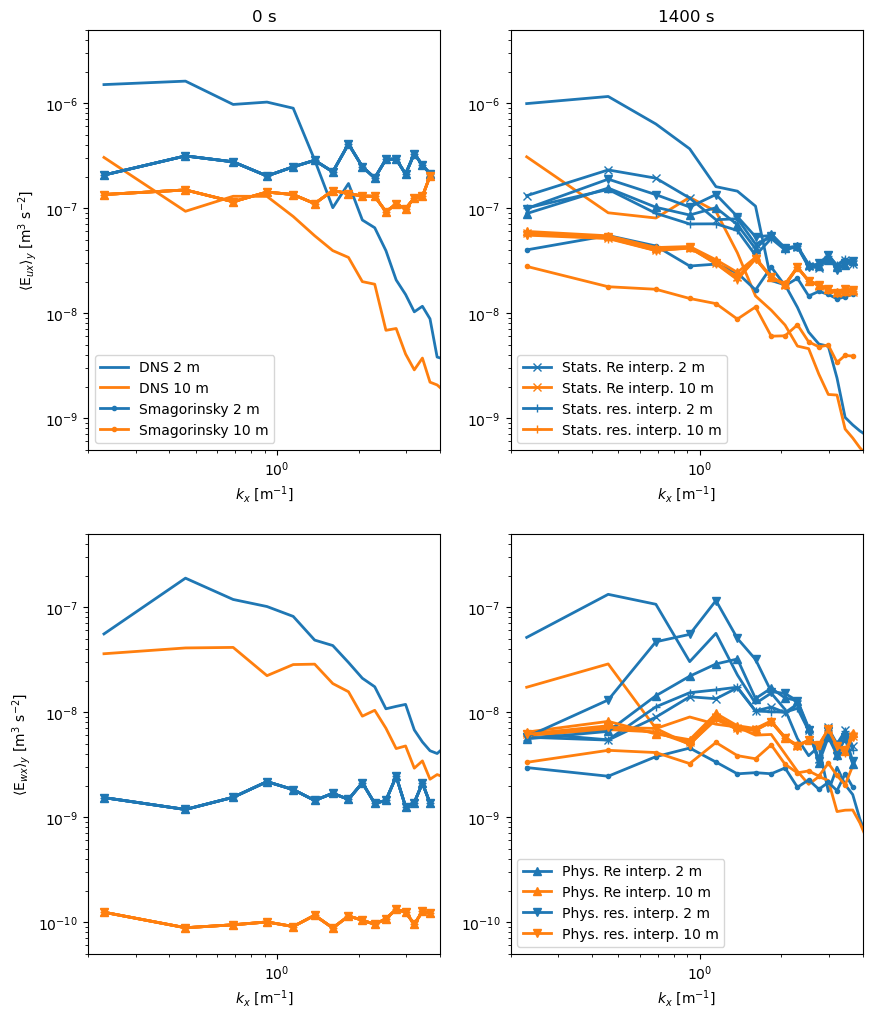

In [6]:
for j in range(len(axs[0])):
    for i in range(len(axs)):
        axs[i,j].set_xlim([2e-1,4e0])
    axs[0,j].set_ylim([5e-10,5e-6])
    axs[1,j].set_ylim([5e-11,5e-7])
        
handles,labels=axs[0,0].get_legend_handles_labels()
nLabel=len(labels)
axs[0,0].legend(ncol=1,handles=handles[:int(2*nLabel/6)],labels=labels[:int(2*nLabel/6)])
axs[0,1].legend(ncol=1,handles=handles[int(2*nLabel/6):int(4*nLabel/6)],labels=labels[int(2*nLabel/6):int(4*nLabel/6)])
axs[1,1].legend(ncol=1,handles=handles[int(4*nLabel/6):],labels=labels[int(4*nLabel/6):])

fig

In [7]:
# save=True
if save:
    plt.figure(fig)
    fmts=["png","eps"]
    for fmt in fmts:
        plt.savefig("Spectra_compareHgtTime_interp."+fmt, format=fmt)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
